In [1]:
#-----------



#IMPORT DES MODULES, MODELES ETC.



#-----------


#visualisation automatique des graphes
%matplotlib inline

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import folium
import shap
import statsmodels.api
import xgboost as xgb
from xgboost import plot_importance

from datetime import date, time, datetime as dt

from sklearn.feature_selection import SelectKBest, f_regression

from sklearn.pipeline import Pipeline

from sklearn.preprocessing import LabelEncoder, StandardScaler, MinMaxScaler

from sklearn.linear_model import RidgeCV, Ridge, LinearRegression, ElasticNetCV, ElasticNet, Lasso, LassoCV
from sklearn.ensemble import GradientBoostingRegressor, RandomForestRegressor, AdaBoostRegressor
from sklearn.tree import DecisionTreeRegressor, plot_tree

from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.model_selection import cross_val_predict, cross_val_score, cross_validate, GridSearchCV

from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

#Désactivation des messages d'avertissements
import warnings
warnings.filterwarnings("ignore")

In [2]:
#-----------



#IMPORT DES JEUX DE DONNEES ET CREATION DU JEU PRINCIPAL



#-----------


#lecture des datasets pour Sept 20 complet à Oct 21 complet
df1 = pd.read_csv('comptage-velo-donnees-compteurs.csv', sep = ';')
df2 = pd.read_csv('comptage-velo-donnees-compteurs-211105.csv', sep = ';')

# Chargement des données météo de Septembre, Octobre 2020 et 2021
meteo = pd.read_csv('meteo_paris.csv', sep =';') 

# Chargement du fichier des arrondissements
arrondissement = pd.read_csv('Arrondissement.csv', sep=';')

# Récupération dans le dataset 2 de la partie manquante d'Octobre 21
mask=(df2['Date et heure de comptage']>'2021-10-21T23:00:00+02:00') & (df2['Date et heure de comptage']<'2021-11-01T00:00:00+02:00')
filtered_df=df2.loc[mask]
filtered_df

#Fusion des deux DataFrame
df=pd.concat([df1,filtered_df],axis=0 )
df=df.reset_index(drop=True)

#vérification des NaN
df.isna().sum()


Identifiant du compteur                       0
Nom du compteur                               0
Identifiant du site de comptage               0
Nom du site de comptage                       0
Comptage horaire                              0
Date et heure de comptage                     0
Date d'installation du site de comptage       0
Lien vers photo du site de comptage           0
Coordonnées géographiques                     0
Identifiant technique compteur             6467
dtype: int64

In [3]:
#-----------



#PREPARATION DU JEU PRINCIPAL



#-----------

# Suppression des colonnes non pertinentes
df.drop(['Identifiant technique compteur','Nom du site de comptage','Identifiant du site de comptage','Identifiant du compteur',
         'Lien vers photo du site de comptage',"Date d'installation du site de comptage"], axis = 1, inplace = True)

# Changement des noms de colonnes pour un texte propre pour Python
df = df.rename({'Date et heure de comptage':'Date_heure_comptage',
                'Nom du compteur':'Nom_compteur',
                'Comptage horaire':'Comptage_horaire',
               "Date d'installation du site de comptage":'Date_installation_site_comptage',
               'Lien vers photo du site de comptage':'Lien_photo_site_comptage',
               'Coordonnées géographiques':'Latitude_longitude'}, 
               axis = 1)


# Transformation de la colonne de date et heure de comptage en datetime pour pouvoir utiliser dt.X
df['Date_heure_comptage'] = pd.to_datetime(df['Date_heure_comptage'], utc = True)


# Récupération des données datetime pour créer des colonnes spécifiques en vue d'analyses supplémentaires
df['Date'] = df['Date_heure_comptage'].dt.date
df['Annee'] = df['Date_heure_comptage'].dt.year
df['Mois_annee'] = df['Date_heure_comptage'].apply(lambda x: x.strftime('%Y-%m'))
df['Mois'] = df['Date_heure_comptage'].dt.month
df['Jour'] = df['Date_heure_comptage'].dt.day
df['Jour_semaine'] = df['Date_heure_comptage'].dt.weekday
df['Heure'] = df['Date_heure_comptage'].dt.time


#Récupération des latitudes et longitudes
df['Latitude'] = df['Latitude_longitude'].apply(lambda x: x.split(',')[0]).astype('float')
df['Longitude'] = df['Latitude_longitude'].apply(lambda x: x.split(',')[1]).astype('float')
df.drop(['Latitude_longitude'], axis = 1, inplace = True)

df.head()

,Nom_compteur,Comptage_horaire,Date_heure_comptage,Date,Annee,Mois_annee,Mois,Jour,Jour_semaine,Heure,Latitude,Longitude
0,97 avenue Denfert Rochereau SO-NE,0.0,2020-09-01 02:00:00+00:00,2020-09-01,2020,2020-09,9,1,1,02:00:00,48.83511,2.33338
1,97 avenue Denfert Rochereau SO-NE,0.0,2020-09-01 01:00:00+00:00,2020-09-01,2020,2020-09,9,1,1,01:00:00,48.83511,2.33338
2,97 avenue Denfert Rochereau SO-NE,14.0,2020-09-01 05:00:00+00:00,2020-09-01,2020,2020-09,9,1,1,05:00:00,48.83511,2.33338
3,97 avenue Denfert Rochereau SO-NE,7.0,2020-09-01 04:00:00+00:00,2020-09-01,2020,2020-09,9,1,1,04:00:00,48.83511,2.33338
4,97 avenue Denfert Rochereau SO-NE,3.0,2020-09-01 03:00:00+00:00,2020-09-01,2020,2020-09,9,1,1,03:00:00,48.83511,2.33338


In [4]:
#-----------



#AJOUT DE VARIABLES PERTINENTES



#-----------


# ---------Ajout de la variable Vacances-----------

#Transformation de Date en datetime
df['Date'] = pd.to_datetime(df['Date'])

#création de la liste de Datetime.Index que l'on transforme en Series entre le début et la fin des vacances
toussaint = pd.Series(pd.date_range(start="2020-10-16", end="2020-11-02"))

#transformation de la Series en array de Datetime puis transformation de l'array en liste
toussaint = toussaint.dt.to_pydatetime().tolist()

noel = pd.Series(pd.date_range(start="2020-12-18", end="2021-01-04"))
noel = noel.dt.to_pydatetime().tolist()

hiver = pd.Series(pd.date_range(start="2021-02-12", end="2021-03-01"))
hiver = hiver.dt.to_pydatetime().tolist()

printemps = pd.Series(pd.date_range(start="2021-04-09", end="2021-04-26"))
printemps = printemps.dt.to_pydatetime().tolist()

ponts_de_mai = pd.Series(pd.date_range(start="2021-05-12", end="2021-05-17"))
ponts_de_mai = ponts_de_mai.dt.to_pydatetime().tolist()

df['Vac_scolaires'] = df.Date.apply(lambda x: 1 if (x in toussaint or x in noel or x in hiver or x in printemps or x in ponts_de_mai) else 0)

# ---------Ajout de la variable Fériés-----------

fer =['01/11/2020','11/11/2020','25/12/2020','01/01/2021','13/04/2021','01/05/2021','08/05/2021','21/05/2021','01/06/2021','14/07/2021','15/08/2021']
date=[dt.strptime(x,'%d/%m/%Y') for x in fer]

df['Feries']=df.Date.apply(lambda x: 1 if x in date else 0)

# ---------Ajout de la variable Confinement-----------

#conf =[30/10/2020-15/12/2020, 20/03/2021-02/05/2021]

df['Confinement'] = 0
df['Confinement'].loc[((df['Date_heure_comptage'] >= "2020-10-30 01:00:00+00:00") & (df['Date_heure_comptage'] <= "2020-12-15 7:00:00+00:00")) |
                      ((df['Date_heure_comptage'] >= "2021-03-20 01:00:00+00:00") & (df['Date_heure_comptage'] <= "2021-05-02 6:00:00+00:00"))] = 1

# ---------Ajout de la variable Couvre-feu-----------

df['Couvre_feu'] = 0
df['Couvre_feu'].loc[((df['Date'] >= "2020-12-15") & (df['Date'] <= "2020-12-22") & ((df['Heure'] >= time(21,0,0)) | (df['Heure'] <= time(6,0,0)))) |
                    ((df['Date'] >= "2021-01-16") & (df['Date'] <= "2021-03-19") & ((df['Heure'] >= time(19,0,0)) | (df['Heure'] <= time(6,0,0)))) |
                    ((df['Date'] >= "2021-03-20") & (df['Date'] <= "2021-05-18") & ((df['Heure'] >= time(20,0,0)) | (df['Heure'] <= time(6,0,0)))) |
                    ((df['Date'] >= "2021-05-19") & (df['Date'] <= "2021-06-08") & ((df['Heure'] >= time(22,0,0)) | (df['Heure'] <= time(6,0,0)))) |
                    ((df['Date'] >= "2021-06-10") & (df['Date'] <= "2021-06-20") & (df['Heure'] <= time(6,0,0))) ] = 1

# ---------Ajout de la variable Sans-Voitures-----------

df['Journee_sans_voitures'] = 0
df['Journee_sans_voitures'].loc[((df['Date_heure_comptage'] >= "2021-09-19 12:00:00+00:00") & (df['Date_heure_comptage'] <= "2021-09-19 18:00:00+00:00"))] = 1

# ---------Ajout de la variable Week-end-----------

df['Weekend'] = 0
df['Weekend'].loc[(df['Jour_semaine'] == 5) | (df['Jour_semaine'] == 6)] = 1

# ---------Ajout de la variable Vacances été-----------

vac_ete = pd.Series(pd.date_range(start="2021-07-06", end="2021-09-02"))
vac_ete = vac_ete.dt.to_pydatetime().tolist()

df['Vac_ete']=df.Date.apply(lambda x: 1 if x in vac_ete else 0)

# ---------Ajout de la variable Météo-----------

# Mise au format de la variable dateen pd.to_datetime
meteo['Date'] = pd.to_datetime(meteo['Date'])
df['Date']=pd.to_datetime(df['Date'])

# On fusionne les deux DataFrame
df = df.merge(right = meteo, on='Date', how = 'left')

# Affichage pour vérifier que tout s'est bien passé
df.tail(20)

# On fusionne les df avec les arrondissements
df = df.merge(right = arrondissement, on='Nom_compteur', how = 'left')

#Vérification des NaN
df.isna().any().sum()

0

In [550]:
#-----------



#DATA VISUALISATION



#-----------


#-----------CORRELATION ANOVA ENTRE MOIS ET TRAFIC--------------

result = statsmodels.formula.api.ols('Comptage_horaire ~ Mois_annee', data=df).fit()
table = statsmodels.api.stats.anova_lm(result)

display(table)

#-----------CORRELATION ANOVA ENTRE DATES ET TRAFIC--------------

import statsmodels.api
result = statsmodels.formula.api.ols('Comptage_horaire ~ Date', data=df).fit()
table = statsmodels.api.stats.anova_lm(result)

display(table)


#-----------CORRELATION ANOVA ENTRE JOURS ET TRAFIC--------------

result = statsmodels.formula.api.ols('Comptage_horaire ~ Jour_semaine', data=df).fit()
table = statsmodels.api.stats.anova_lm(result)

display(table)



#-----------CORRELATION ANOVA ENTRE HEURES ET TRAFIC--------------

result = statsmodels.formula.api.ols('Comptage_horaire ~ Heure', data=df).fit()
table = statsmodels.api.stats.anova_lm(result)

display(table)

#-----------CORRELATION ENTRE TRAFIC ET TEMPERATURE--------------

import statsmodels.api
result = statsmodels.formula.api.ols('Comptage_horaire ~ Temperature_moy', data=df).fit()
table = statsmodels.api.stats.anova_lm(result)

display(table)

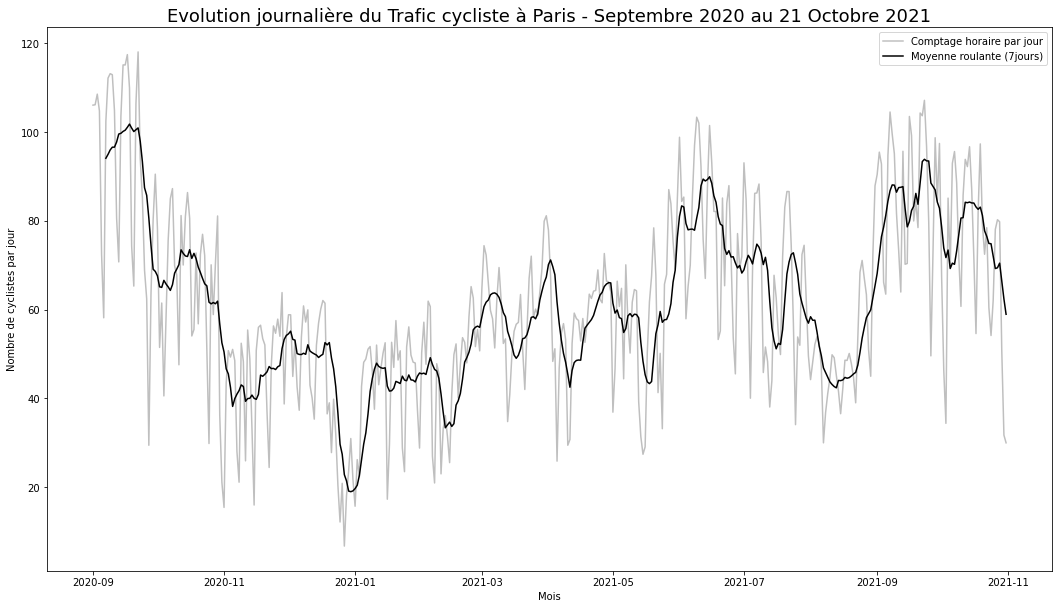

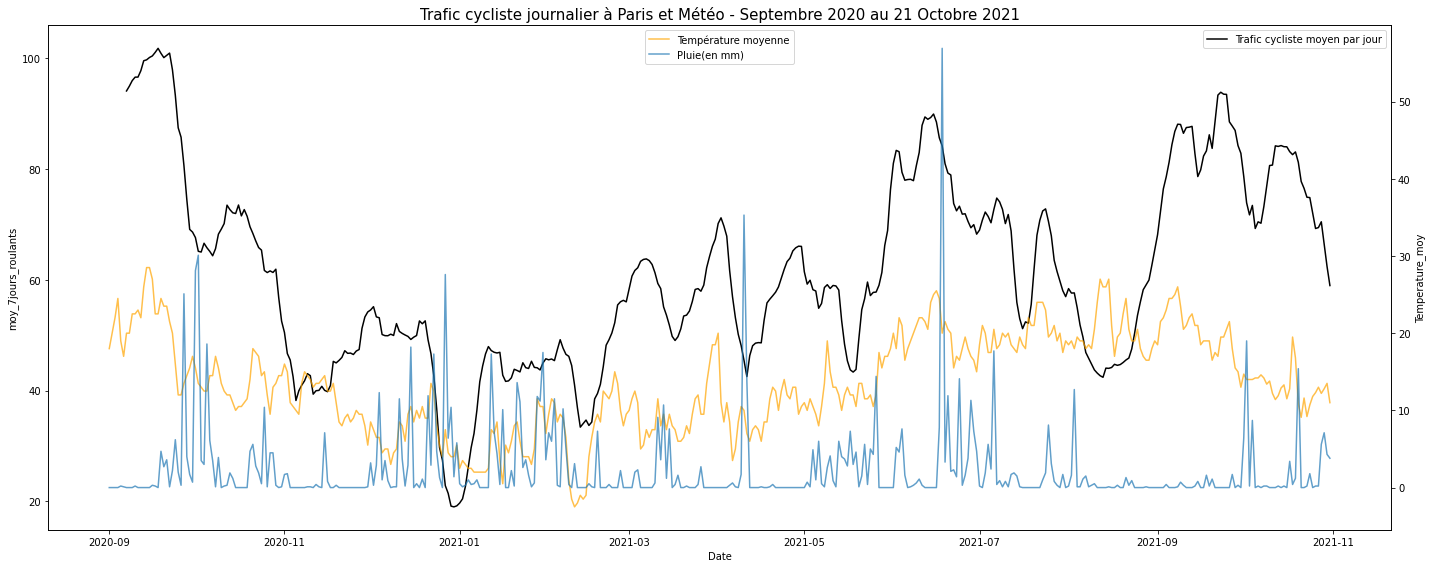

<Figure size 1080x1080 with 0 Axes>

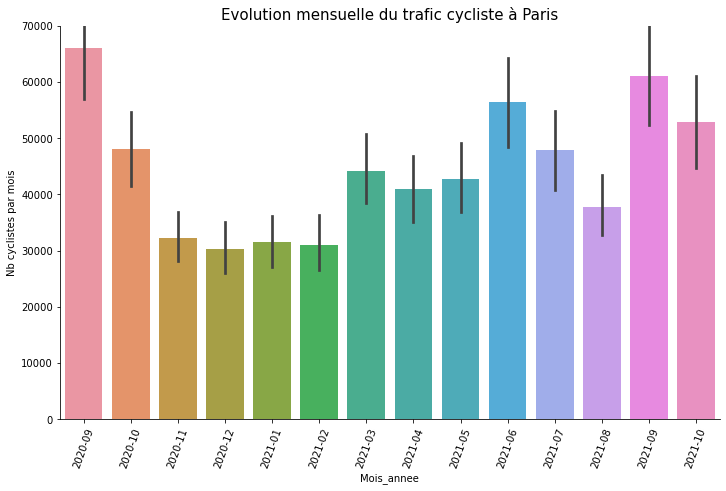

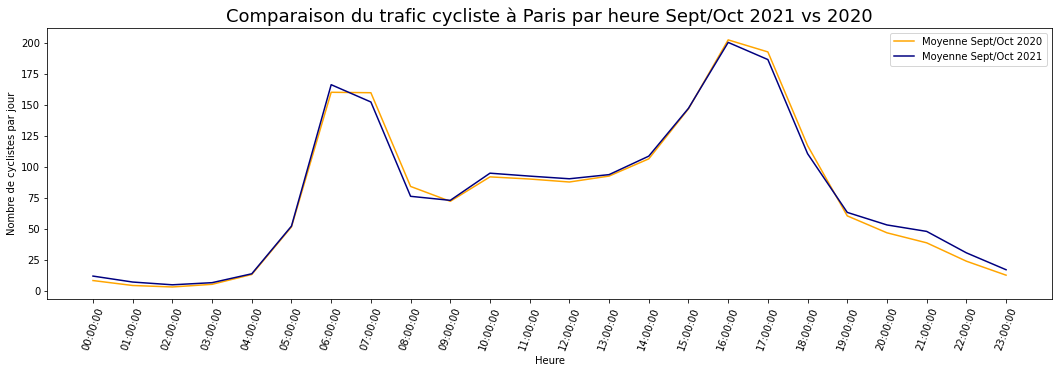

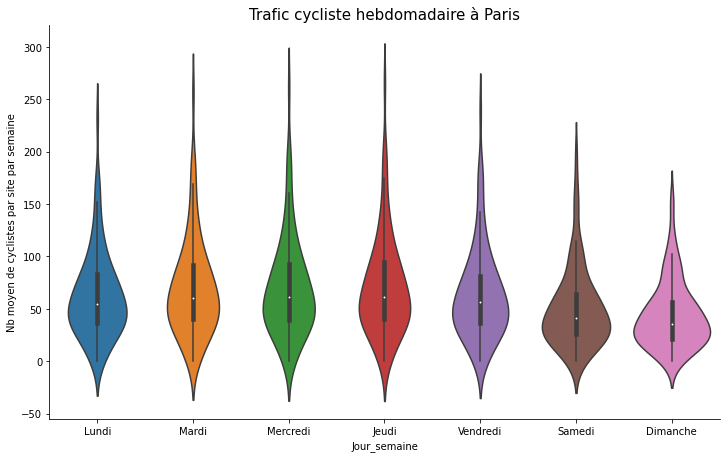

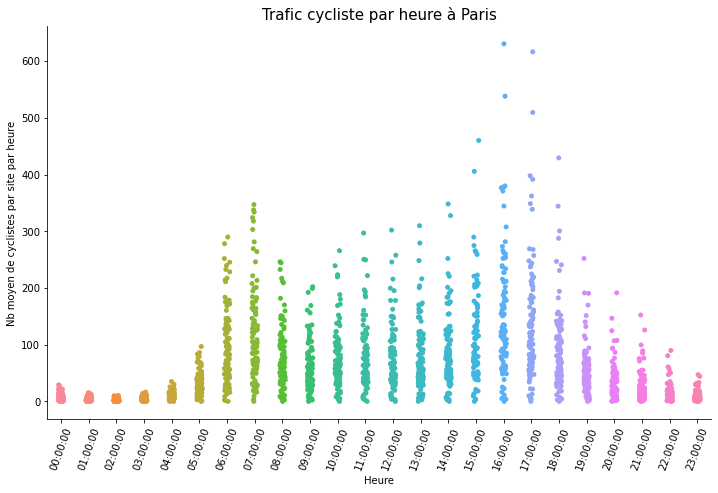

<Figure size 4320x5040 with 0 Axes>

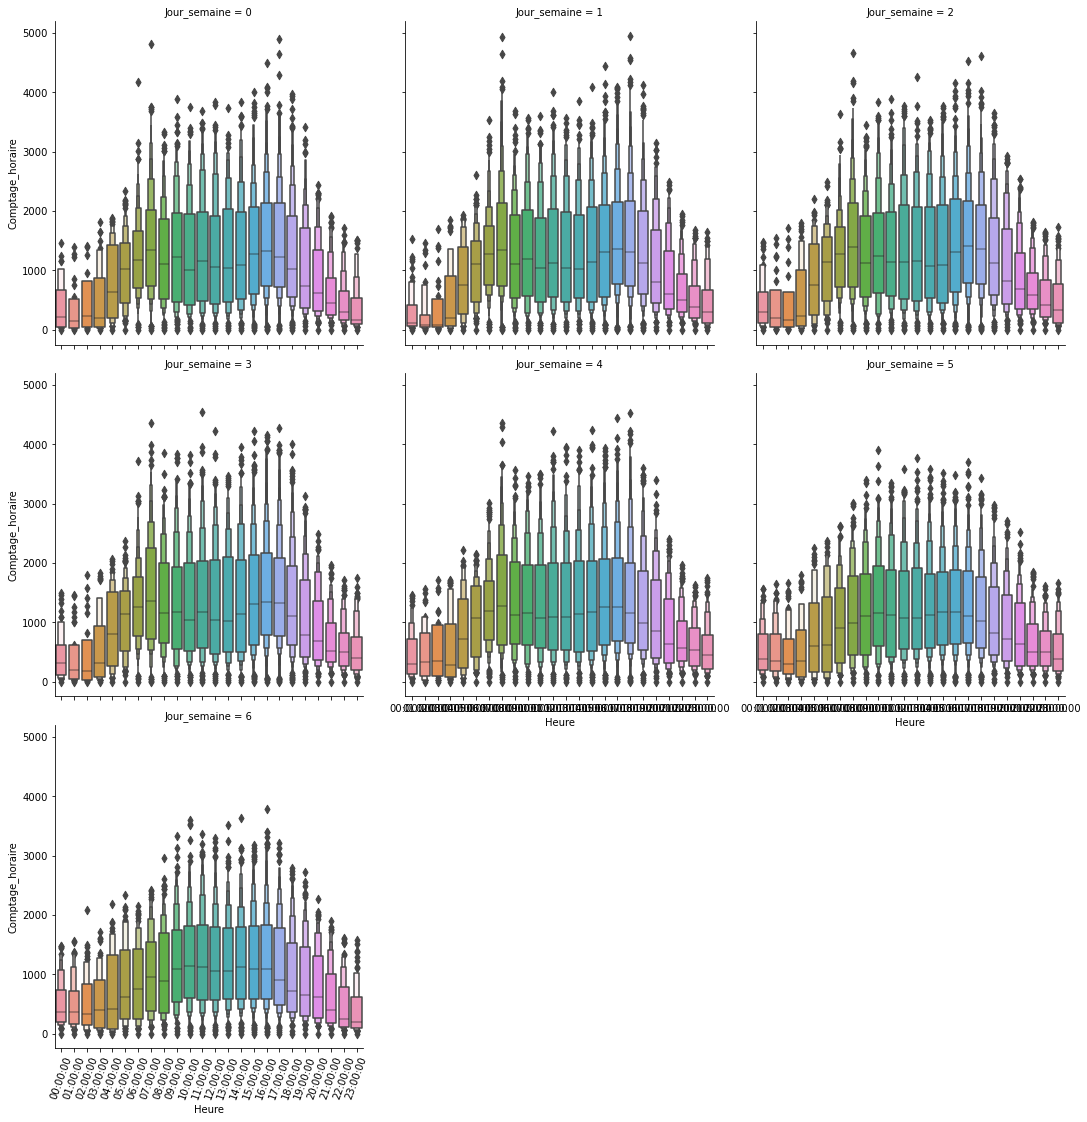

<Figure size 1440x1080 with 0 Axes>

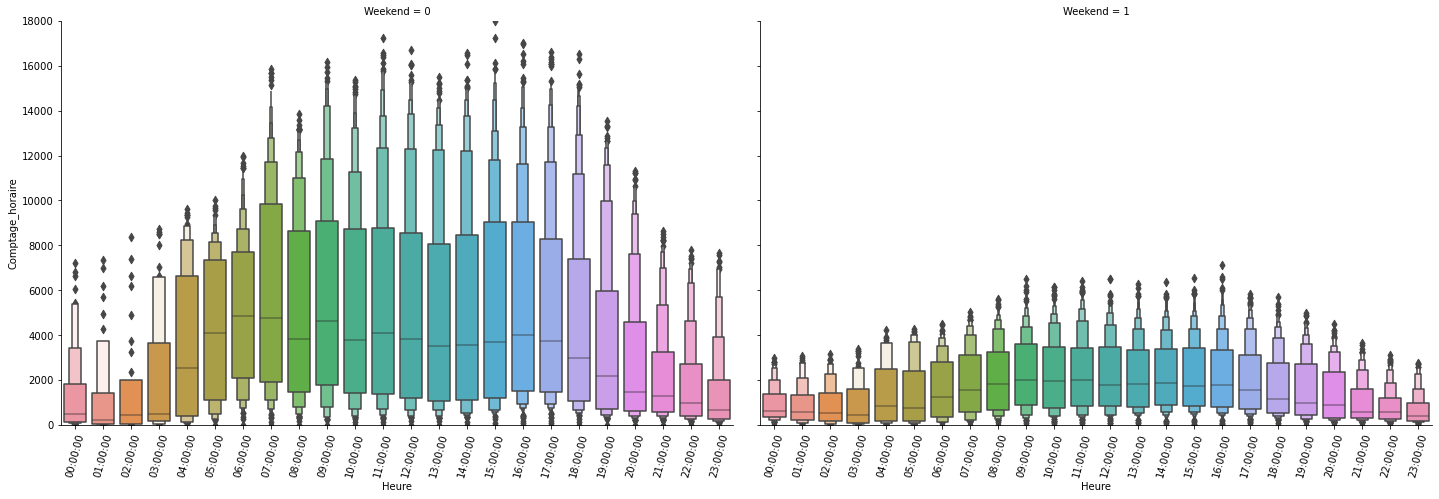

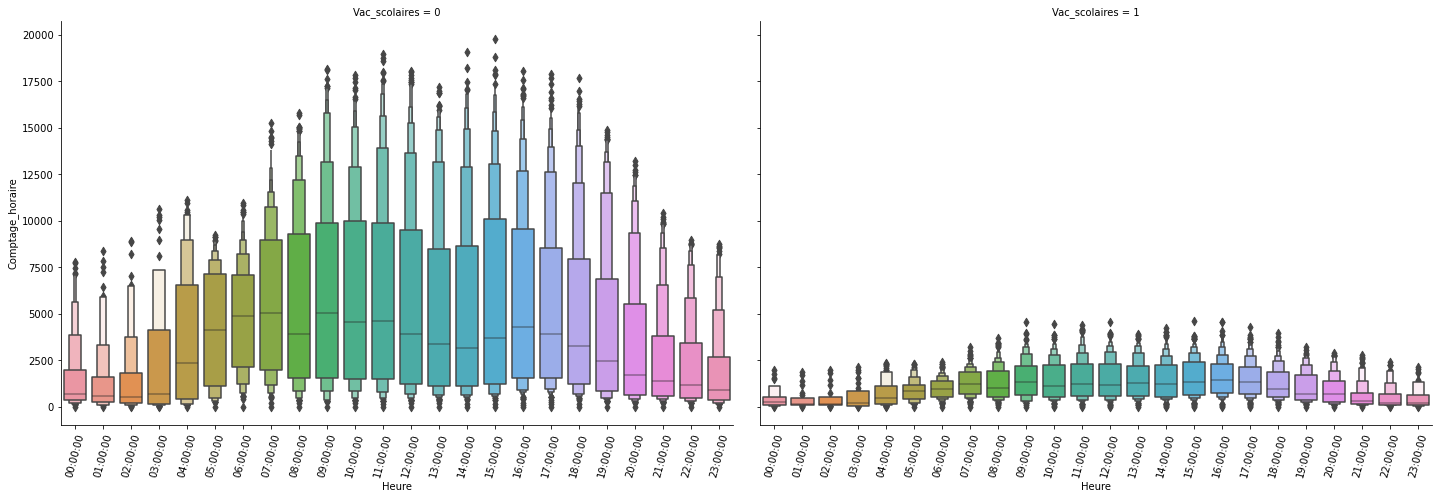

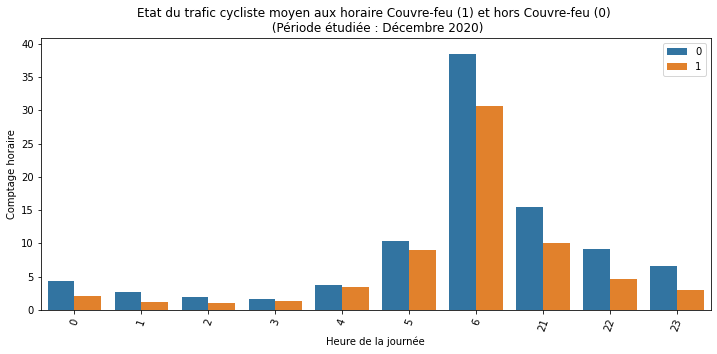

In [5]:
#-----------TRAFIC ANNUEL--------------

compteur_annuel = df.groupby(['Date'], as_index = False).agg({'Comptage_horaire' :'mean', 'Temperature_moy' : 'mean', 'Pluie_en_mm' : 'mean'})
compteur_annuel['moy_7jours_roulants'] = compteur_annuel.Comptage_horaire.rolling(7).mean()

plt.figure(figsize = (18, 10)) 
sns.lineplot(x='Date', y='Comptage_horaire', color = 'grey', data=compteur_annuel, label = 'Comptage horaire par jour', alpha = 0.5)
sns.lineplot(x='Date', y='moy_7jours_roulants', color = 'black', data=compteur_annuel, label = 'Moyenne roulante (7jours)')
        
plt.title('Evolution journalière du Trafic cycliste à Paris - Septembre 2020 au 21 Octobre 2021', fontsize=18)
plt.xlabel('Mois')
plt.ylabel('Nombre de cyclistes par jour');

#-----------ANALYSE TRAFIC CYCLISTE ANNUEL ET METEO --------------

fig, ax = plt.subplots(figsize=[20,8])
sns.lineplot(x='Date', y='moy_7jours_roulants', color='black', data=compteur_annuel, ax=ax, label = 'Trafic cycliste moyen par jour')
ax2 = ax.twinx()
sns.lineplot(x='Date', y='Temperature_moy', color = 'orange', alpha = 0.7, data=compteur_annuel, ax=ax2, label = 'Température moyenne')
plt.title('Trafic cycliste journalier à Paris et Météo - Septembre 2020 au 21 Octobre 2021', fontsize=15);

sns.lineplot(x='Date', y='Pluie_en_mm', alpha = 0.7, data=compteur_annuel, label= 'Pluie(en mm)')
plt.legend(loc = 'upper center');

#-----------COMPARATIF TRAFIC MENSUEL SEPTEMBRE ET OCTOBRE 2021 VS 2020 --------------

compteur_mensuel = df.groupby(['Mois_annee', 'Nom_compteur'], as_index = False).agg({'Comptage_horaire' :'sum'})

plt.figure(figsize=(15,15))
sns.catplot(x='Mois_annee', y='Comptage_horaire', kind='bar', data=compteur_mensuel, height=6, aspect=10/6)
plt.title('Evolution mensuelle du trafic cycliste à Paris', fontsize = 15)
plt.ylabel('Nb cyclistes par mois')
plt.xticks(rotation = 70)
plt.ylim(0,70000);

df_sept_oct20 = df[(df.Mois_annee == '2020-09') | (df.Mois_annee == '2020-10')]
df_sept_oct20['Heure'] = df_sept_oct20['Heure'].apply(lambda x: x.strftime('%H:%M:%S'))
sept_oct20 = df_sept_oct20.groupby(['Mois_annee','Heure'], as_index = False).agg({'Comptage_horaire' :'mean'})

df_sept_oct21 = df[(df.Mois_annee == '2021-09') | (df.Mois_annee == '2021-10')]
df_sept_oct21['Heure'] = df_sept_oct21['Heure'].apply(lambda x: x.strftime('%H:%M:%S'))
sept_oct21 = df_sept_oct21.groupby(['Mois_annee','Heure'], as_index = False).agg({'Comptage_horaire' :'mean'})

plt.figure(figsize = (18, 5)) 
sns.lineplot(x='Heure', y='Comptage_horaire',ci = None, color = 'orange', data = sept_oct20, label = 'Moyenne Sept/Oct 2020')
sns.lineplot(x='Heure', y='Comptage_horaire',ci = None, color = 'navy', data = sept_oct21, label = 'Moyenne Sept/Oct 2021')
plt.title('Comparaison du trafic cycliste à Paris par heure Sept/Oct 2021 vs 2020', fontsize=18)
plt.xlabel('Heure')
plt.xticks(rotation = 70)
plt.ylabel('Nombre de cyclistes par jour');

# #-----------TRAFIC PAR MOIS ET PAR HEURE --------------
# mois = df.groupby(['Mois_annee','Heure','Comptage_horaire'], as_index = False).agg({'Comptage_horaire' : 'sum'})

# # plt.figure(figsize=(30,50));
# catplot = sns.catplot(x='Heure', y='Comptage_horaire', kind='bar', col='Mois_annee', col_wrap=2, data=mois, height=6, aspect=10/6)
# plt.ylim(0,1100)


# for ax in catplot.axes:
#     plt.setp(ax.get_xticklabels(), visible=True, rotation=75)
#     plt.subplots_adjust(hspace=0.2, top = 1);
    
#-----------TRAFIC HEBDOMADAIRE--------------

compteur_hebdo = df.groupby(['Jour_semaine', 'Nom_compteur'], as_index = False).agg({'Comptage_horaire' :'mean'})
compteur_hebdo

sns.catplot(x='Jour_semaine', y='Comptage_horaire', kind='violin', data = compteur_hebdo, height=6, aspect=10/6)
plt.xticks((0,1,2,3,4,5,6),('Lundi', 'Mardi', 'Mercredi', 'Jeudi', 'Vendredi', 'Samedi', 'Dimanche'))
plt.title('Trafic cycliste hebdomadaire à Paris', fontsize = 15)
plt.ylabel('Nb moyen de cyclistes par site par semaine');

#-----------TRAFIC HORAIRE--------------

comptage_heure = df.groupby(['Heure', 'Nom_compteur'], as_index=False).agg({'Comptage_horaire': 'mean'})
comptage_heure

sns.catplot(x='Heure', y='Comptage_horaire', data = comptage_heure, height=6, aspect=10/6);
plt.title('Trafic cycliste par heure à Paris', fontsize = 15)
plt.ylabel('Nb moyen de cyclistes par site par heure')
plt.xticks(rotation = 70);


#-----------TRAFIC PAR SEMAINE ET PAR HEURE --------------
essai = df.groupby(['Jour_semaine','Heure','Comptage_horaire'], as_index = False).agg({'Comptage_horaire' : 'sum'})

plt.figure(figsize=(60,70));

sns.catplot(x='Heure', y='Comptage_horaire', kind='boxen', col='Jour_semaine', col_wrap=3, data=essai);

plt.xlabel('Heure');
plt.xticks(rotation = 70);
    
#-----------TRAFIC WEEK-END PAR HEURE --------------
weekend = df.groupby(['Weekend','Heure','Comptage_horaire'], as_index = False).agg({'Comptage_horaire' : 'sum'})

plt.figure(figsize=(20,15));
fig.tight_layout()
weekend_plot = sns.catplot(x='Heure', y='Comptage_horaire', kind='boxen', col='Weekend', col_wrap=2, data=weekend, height=6, aspect=10/6);
plt.ylim(0,18000)

for ax in weekend_plot.axes:
    plt.setp(ax.get_xticklabels(), visible=True, rotation=75)
    plt.subplots_adjust(hspace=0.2, top = 1);
    
#-----------TRAFIC VACANCES PAR HEURE --------------
vac_scolaires = df.groupby(['Vac_scolaires','Heure','Comptage_horaire'], as_index = False).agg({'Comptage_horaire' : 'sum'})

vac_scolaire_plot = sns.catplot(x='Heure', y='Comptage_horaire', kind='boxen', col='Vac_scolaires', col_wrap=2, data=vac_scolaires, height=6, aspect=10/6);
# plt.ylim(0,8000)

for ax in vac_scolaire_plot.axes:
    plt.setp(ax.get_xticklabels(), visible=True, rotation=75)
    plt.subplots_adjust(hspace=0.2, top = 1);
 

   
#-----------IMPACT TRAFIC PAR HEURE PENDANT LE COUVRE-FEU DE DECEMBRE 2020--------------

#Création d'un dataframe contenant une période de 8 jours avec couvre feu sur les heures de couvre-feu
df_couvrefeu = df.loc[((df['Date'] >= "2020-12-15") & (df['Date'] <= "2020-12-22") & ((df['Heure'] >= time(21,0,0)) | (df['Heure'] <= time(6,0,0))))]
#Création d'un dataframe contenant une période des 8 jours précédant la période concernée au-dessus mais sans couvre feu sur les mêmes heures
df_couvrefeu0 = df.loc[(df['Date'] >= "2020-12-1") & (df['Date'] <= "2020-12-8") & ((df['Heure'] >= time(21,0,0)) | (df['Heure'] <= time(6,0,0)))]

df_couvrefeu = df_couvrefeu.groupby(['Couvre_feu','Jour_semaine','Heure'], as_index = False).agg({'Comptage_horaire' : 'mean'})
df_couvrefeu0 = df_couvrefeu0.groupby(['Couvre_feu','Jour_semaine','Heure'], as_index = False).agg({'Comptage_horaire' : 'mean'})

df_couvrefeux = pd.concat([df_couvrefeu,df_couvrefeu0])
df_couvrefeux['Heure'] = df_couvrefeux['Heure'].apply(lambda x: int(x.strftime('%H')))

df_couvrefeux.loc[df_couvrefeux['Heure'] == 21]



plt.figure(figsize = (12,5))
sns.barplot(df_couvrefeux.Heure, y='Comptage_horaire', ci = 0, hue = 'Couvre_feu', data = df_couvrefeux)
# sns.barplot(df_couvrefeu0.Heure, y='Comptage_horaire', color = 'red', alpha = 0.8,ci = None, data = df_couvrefeu0)
# sns.catplot(df_couvrefeu0.Heure, y='Comptage_horaire', color = 'red',ci = None, data = df_couvrefeu0)
plt.xticks(rotation = 70)
plt.ylabel('Comptage horaire')
plt.xlabel('Heure de la journée')
plt.title('Etat du trafic cycliste moyen aux horaire Couvre-feu (1) et hors Couvre-feu (0) \n (Période étudiée : Décembre 2020)', fontsize = 12)

plt.legend();

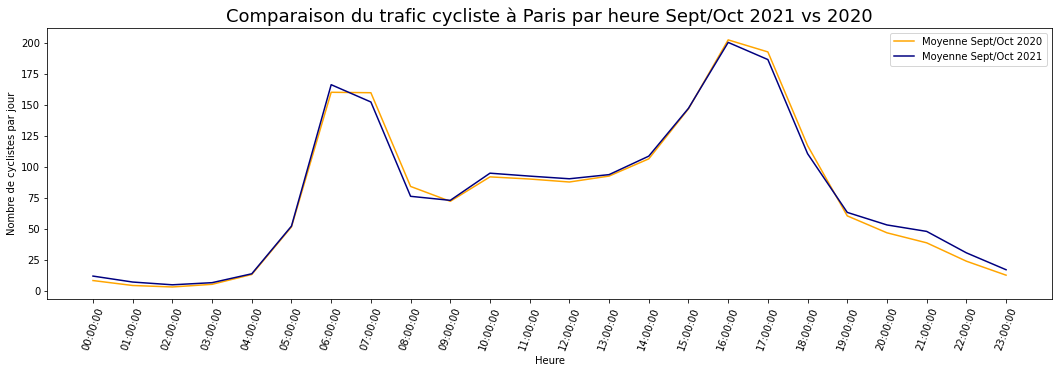

In [6]:
df_sept_oct20 = df[(df.Mois_annee == '2020-09') | (df.Mois_annee == '2020-10')]
df_sept_oct20['Heure'] = df_sept_oct20['Heure'].apply(lambda x: x.strftime('%H:%M:%S'))
sept_oct20 = df_sept_oct20.groupby(['Mois_annee','Heure'], as_index = False).agg({'Comptage_horaire' :'mean'})

df_sept_oct21 = df[(df.Mois_annee == '2021-09') | (df.Mois_annee == '2021-10')]
df_sept_oct21['Heure'] = df_sept_oct21['Heure'].apply(lambda x: x.strftime('%H:%M:%S'))
sept_oct21 = df_sept_oct21.groupby(['Mois_annee','Heure'], as_index = False).agg({'Comptage_horaire' :'mean'})

plt.figure(figsize = (18, 5)) 
sns.lineplot(x='Heure', y='Comptage_horaire',ci = None, color = 'orange', data = sept_oct20, label = 'Moyenne Sept/Oct 2020')
sns.lineplot(x='Heure', y='Comptage_horaire',ci = None, color = 'navy', data = sept_oct21, label = 'Moyenne Sept/Oct 2021')
plt.title('Comparaison du trafic cycliste à Paris par heure Sept/Oct 2021 vs 2020', fontsize=18)
plt.xlabel('Heure')
plt.xticks(rotation = 70)
plt.ylabel('Nombre de cyclistes par jour');

,Comptage_horaire
Vac_scolaires,
0,64.528475
1,46.829375


,Comptage_horaire
Weekend,
0,66.941543
1,47.257380


,Comptage_horaire
Feries,
0,61.792637
1,43.014807


,Comptage_horaire
Confinement,
0,63.856416
1,51.559927


,Mois_annee,Comptage_horaire
0,2020-09,91.726836
1,2020-10,64.599348


,Mois_annee,Comptage_horaire
0,2021-09,86.579308
1,2021-10,72.044339


,Mois_annee,Pluie_en_mm
0,2020-09,1.812534
1,2020-10,4.375774


,Mois_annee,Pluie_en_mm
0,2021-09,0.245635
1,2021-10,2.533695


,Mois_annee,Weekend,Comptage_horaire,Mois,Annee
0,2020-09,0,101.757936,9,2020
1,2020-09,1,64.194124,9,2020
2,2020-10,0,71.469985,10,2020
3,2020-10,1,47.726340,10,2020
0,2021-09,0,92.583501,9,2021
1,2021-09,1,70.047697,9,2021
2,2021-10,0,81.679922,10,2021
3,2021-10,1,51.712982,10,2021


<Figure size 864x360 with 0 Axes>

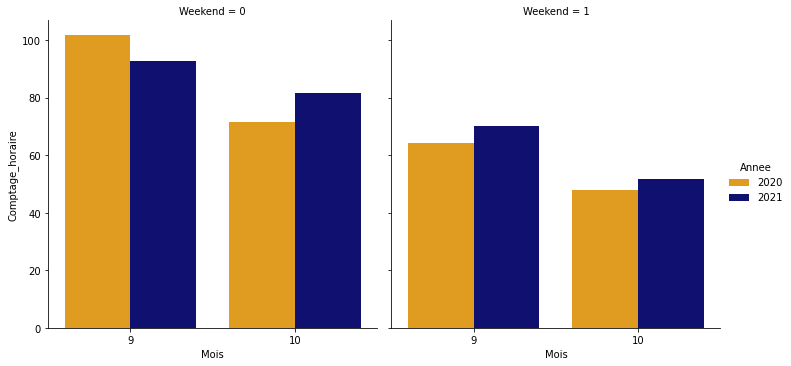

In [7]:
# Comparatif du comptage horaire suivant des périodicités et événements exceptionnels

display(df.groupby(['Vac_scolaires']).agg({'Comptage_horaire' : 'mean'}))
display(df.groupby(['Weekend']).agg({'Comptage_horaire' : 'mean'}))
display(df.groupby(['Feries']).agg({'Comptage_horaire' : 'mean'}))
display(df.groupby(['Confinement']).agg({'Comptage_horaire' : 'mean'}))

# Vacances scolaire : -27,4% de trafic
# Week-end : -29,4% de trafic
# Fériés : -30,4% de trafic
# Confinement : -19.3% de trafic

display(df_sept_oct20.groupby(['Mois_annee'], as_index = False).agg({'Comptage_horaire' :'mean'}))
display(df_sept_oct21.groupby(['Mois_annee'], as_index = False).agg({'Comptage_horaire' :'mean'}))

# Septembre 21 : -5.6% vs 2020
# Octobre 21 : +11.5% vs 2020

display(df_sept_oct20.groupby(['Mois_annee'], as_index = False).agg({'Pluie_en_mm':'mean'}))
display(df_sept_oct21.groupby(['Mois_annee'], as_index = False).agg({'Pluie_en_mm':'mean'}))

# Comparatif du comptage horaire des mois de Septembre et Octobre 2021 vs 2020 en semaine vs le week-end

annee2020 = df_sept_oct20.groupby(['Mois_annee', 'Weekend'], as_index = False).agg({'Comptage_horaire':'mean'})
annee2021 = df_sept_oct21.groupby(['Mois_annee', 'Weekend'], as_index = False).agg({'Comptage_horaire':'mean'})

comparaison = pd.concat([annee2020, annee2021], axis=0)
comparaison['Mois'] = comparaison['Mois_annee'].apply(lambda x : x[-2:]).astype(int)
comparaison['Annee'] = comparaison['Mois_annee'].apply(lambda x : x[:-3]).astype(int)

display(comparaison)

# Affichage du Graphe
plt.figure(figsize = (12,5))
sns.catplot(x='Mois', y='Comptage_horaire', kind = 'bar', hue = 'Annee', col = 'Weekend', palette = sns.color_palette(['orange', 'navy']), data = comparaison);
# plt.title('Comparaison Sept/Oct 2021 vs 20', fontsize = 12);

# Septembre 21 : -5.6%
    # Semaine : -9%
    # Week-end : +9%
# Octobre 21 : +11.5%
    # Semaine : +14.3%
    # Week-end : +8,4%

In [9]:
#-----------VISUALISATION GEOGRAPHIQUE--------------

#Création d'un dataframe pour la création de la carte représentant les compteurs géographiquement
df_loc = df[['Nom_compteur','Latitude','Longitude','Comptage_horaire']]

#Groupby pour obtenir les noms de compteurs latitude et longitude avec la moyenne des comptages horaire
df_loc = df_loc.groupby(['Nom_compteur', 'Latitude','Longitude'])[['Comptage_horaire']].mean()
df_loc.reset_index(inplace=True)

map = folium.Map(location=[df_loc.Latitude.mean(), df_loc.Longitude.mean()], zoom_start=12.5, control_scale=True)

for index, data in df_loc.iterrows():
    folium.Marker([data["Latitude"], data["Longitude"]], popup=data["Nom_compteur"]).add_to(map)

display(map)

#Ajout d'une colonne à df_loc pour séparer la variable comptage horaire en 4 plages auxquelles on attribuera différentes couleurs
df_loc['Marker_color'] = pd.cut(df_loc['Comptage_horaire'], bins = 4, labels = ['dodgerblue','limegreen','yellow','orange'])

map = folium.Map(location=[df_loc.Latitude.mean(), df_loc.Longitude.mean()], zoom_start=12.5, control_scale=True)

#Création des cercles de couleur et de taille changeant fonction de la valeur du comptage horaire
for index, data in df_loc.iterrows():
    folium.Circle([data["Latitude"], data["Longitude"]], popup=data["Comptage_horaire"], radius = data['Comptage_horaire']*3, color = "w", fill_color = data['Marker_color'], fill_opacity = 0.4).add_to(map)

for index, data in df_loc.loc[df_loc["Nom_compteur"] == "28 boulevard Diderot E-O"].iterrows():
    folium.Marker([data["Latitude"], data["Longitude"]], popup=data["Comptage_horaire"], tooltip = "Compteur le moins déclenché").add_to(map)

for index, data in df_loc.loc[df_loc["Nom_compteur"] == "Totem 73 boulevard de Sébastopol S-N"].iterrows():
    folium.Marker([data["Latitude"], data["Longitude"]], popup=data["Comptage_horaire"], tooltip = "Compteur le plus déclenché").add_to(map) 
    
display(map)

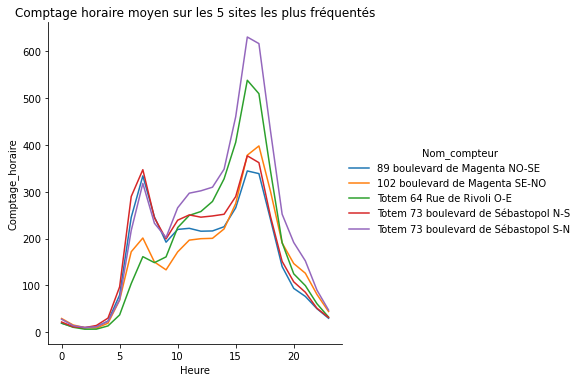

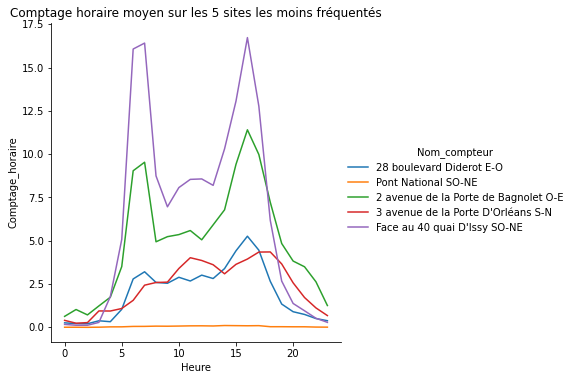

In [8]:
#---------création d'un dataframe contenant les infos des 5 meilleurs compteurs---------
compteur_top5 = df.copy()

#Tri du dataframe sur les 5 compteurs les plus fréquentés
compteur_top5 = compteur_top5.groupby(['Nom_compteur'], as_index = False).agg({'Comptage_horaire':'mean'}).sort_values('Comptage_horaire', ascending = False).head()

#Récupération de la liste des 5 meilleurs compteurs
top5 = compteur_top5['Nom_compteur']

#Récupération des données complètes pour le top5 compteur
compteur_top5 = df.loc[df['Nom_compteur'].isin(top5)]

#Transformation du type datetime.time en integer pour utiliser dans notre graphique
compteur_top5['Heure'] = compteur_top5['Heure'].apply(lambda x: int(x.strftime('%H')))

sns.relplot(x='Heure', y='Comptage_horaire', ci=None, hue = 'Nom_compteur', kind = 'line', data=compteur_top5);
plt.title("Comptage horaire moyen sur les 5 sites les plus fréquentés");

#---------création d'un dataframe contenant les infos des 5 pires compteurs-------------
compteur_flop5 = df.copy()

#Tri du dataframe sur les 5 compteurs les moins fréquentés
compteur_flop5 = compteur_flop5.groupby(['Nom_compteur'], as_index = False).agg({'Comptage_horaire':'mean'}).sort_values('Comptage_horaire').head()

#Récupération de la liste des 5 pires compteurs
flop5 = compteur_flop5['Nom_compteur']

#Récupération des données complètes pour le flop5 compteur
compteur_flop5 = df.loc[df['Nom_compteur'].isin(flop5)]

compteur_flop5['Heure'] = compteur_flop5['Heure'].apply(lambda x: int(x.strftime('%H')))

sns.relplot(x='Heure', y='Comptage_horaire', ci=None, hue = 'Nom_compteur', kind = 'line', data=compteur_flop5);
plt.title("Comptage horaire moyen sur les 5 sites les moins fréquentés");

In [15]:
#-----------



#DATA VISUALISATION



#-----------

#création d'un nouveau df de travail
df_ml = df.copy()

#-----------Préparation de Données--------------

# Encodage des variables catégorielles
le = LabelEncoder()
df_ml['Mois_annee'] = le.fit_transform(df_ml['Mois_annee'])
df_ml['Nom_compteur'] = le.fit_transform(df_ml['Nom_compteur'])
df_ml['Arrondissement'] = le.fit_transform(df_ml['Arrondissement'])

In [16]:
# --------------------------------- AJOUT DE VARIABLES EFFET MEMOIRE : 2EME ITERATION -------------------------------------------------

# Ajout des variables d'effet mémoire comptage H-1 -2 et -3

df_ml['Comptage_h1'] = df_ml['Comptage_horaire']
df_ml['Comptage_h2'] = df_ml['Comptage_horaire']
df_ml['Comptage_h3'] = df_ml['Comptage_horaire']

   
df_ml = df_ml.sort_values(['Nom_compteur','Date','Heure'])

df_ml.Comptage_h1 = df_ml.Comptage_h1.shift(1)
df_ml.Comptage_h2 = df_ml.Comptage_h2.shift(2)
df_ml.Comptage_h3 = df_ml.Comptage_h3.shift(3)

#X = df1.groupby(['Nom_compteur','Date','Comptage_horaire'])
#df1.groupby('Nom_compteur')['Comptage_horaire'].transform(lambda x: x.shift(1))
#df1.groupby('Nom_compteur')['Comptage_horaire']

# Ajout des variables d'effet mémoire comptage j-1 2 et 3

df_ml['Comptage_j1'] = df_ml['Comptage_horaire']
df_ml['Comptage_j2'] = df_ml['Comptage_horaire']
df_ml['Comptage_j3'] = df_ml['Comptage_horaire']


df_ml.Comptage_j1 = df_ml.Comptage_j1.shift(24)
df_ml.Comptage_j2 = df_ml.Comptage_j2.shift(24*2)
df_ml.Comptage_j3 = df_ml.Comptage_j3.shift(24*3)

# Ajout des variables d'effet mémoire comptage s-1 2 et 3

df_ml['Comptage_s1'] = df_ml['Comptage_horaire']
df_ml['Comptage_s2'] = df_ml['Comptage_horaire']
df_ml['Comptage_s3'] = df_ml['Comptage_horaire']


df_ml.Comptage_s1 = df_ml.Comptage_s1.shift(24*7)
df_ml.Comptage_s2 = df_ml.Comptage_s2.shift(24*7*2)
df_ml.Comptage_s3 = df_ml.Comptage_s3.shift(24*7*3)

df_ml.head()

,Nom_compteur,Comptage_horaire,Date_heure_comptage,Date,Annee,Mois_annee,Mois,Jour,Jour_semaine,Heure,...,Arrondissement,Comptage_h1,Comptage_h2,Comptage_h3,Comptage_j1,Comptage_j2,Comptage_j3,Comptage_s1,Comptage_s2,Comptage_s3
147433,0,2.0,2020-09-01 01:00:00+00:00,2020-09-01,2020,0,9,1,1,1,...,14,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
147999,0,3.0,2020-09-01 02:00:00+00:00,2020-09-01,2020,0,9,1,1,2,...,14,2.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
148002,0,3.0,2020-09-01 03:00:00+00:00,2020-09-01,2020,0,9,1,1,3,...,14,3.0,2.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
147436,0,14.0,2020-09-01 04:00:00+00:00,2020-09-01,2020,0,9,1,1,4,...,14,3.0,3.0,2.0,NaN,NaN,NaN,NaN,NaN,NaN
148005,0,76.0,2020-09-01 05:00:00+00:00,2020-09-01,2020,0,9,1,1,5,...,14,14.0,3.0,3.0,NaN,NaN,NaN,NaN,NaN,NaN


In [17]:
# Remplacement NaN nouvelles colonnes "effet mémoire"

df_ml = df_ml.groupby(['Nom_compteur','Jour_semaine','Heure']).transform(lambda x: x.fillna(x.mean()))

df_ml.isna().any().sum()

0

In [18]:
#------------ SPLIT-------------------

X_train = df_ml[df_ml['Jour'] <= 24]
X_test = df_ml[df_ml['Jour'] > 24]
y_train = df_ml[df_ml['Jour'] <= 24]
y_test = df_ml[df_ml['Jour'] > 24]

X_train = X_train.drop(['Comptage_horaire','Date_heure_comptage','Date'], axis = 1)

X_test = X_test.drop(['Comptage_horaire','Date_heure_comptage','Date'], axis = 1)
                      
y_train = y_train[['Comptage_horaire']]

y_test = y_test[['Comptage_horaire']]

L alpha le plus performant est : 0.01
Score Ridge CV : 0.18351514217126252
Score Ridge CV : 0.1812747860087467
RMSE Ridge de Train : 80.49239059366185
RMSE Ridge de Test : 76.557210882447
Score Régression Linéaire de train : 0.1835145745264608
Score Régression Linéaire de test : 0.1812125983185654
RMSE train : 80.49241857402103
RMSE test : 76.56011834494336
Alpha avec la meilleure performance: 0.0005
Score Lasso de train : 0.18343540777776057
Score Lasso de test : 0.18185199375998184
RMSE train : 80.49632076775069
RMSE test : 76.5302194047219
Lasso a gardé 21 et a éliminé les 0 autres variables
Score Elastic Net de train : 0.18239802320177445
Score Elastic Net de test : 0.1799605904695184
RMSE train : 80.5474368321076
RMSE test : 76.61863002596374
moyenne : 10.077897699994491
ecart-type : 4.44710414706554


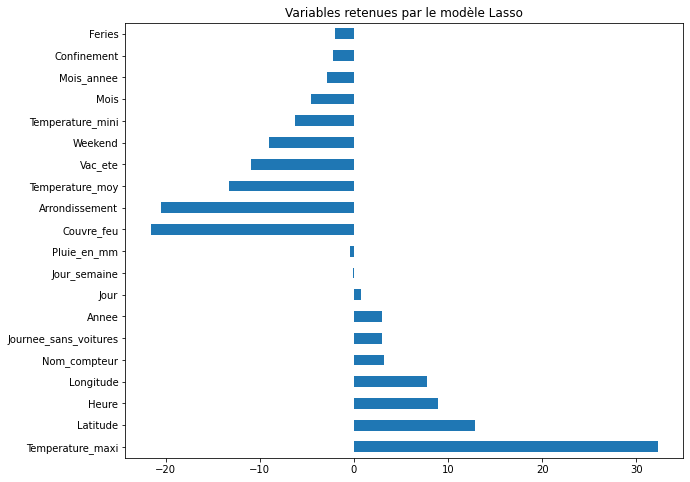

In [712]:
#----------------------------------------------#1ERE ITERATION------------------------------------



# --------------------NORMALISATION --------------


# Normalisation
scaler = StandardScaler()
X_train_scaled= scaler.fit_transform(X_train)
X_test_scaled= scaler.transform(X_test)




#-------------------- MODELE RIDGE --------------


# Instanciation du modèle de régression RidgeCV

ridge = RidgeCV(alphas = (0.001, 0.01, 0.1, 0.3, 0.7, 1, 10, 50, 100))
ridge.fit(X_train_scaled, y_train)

# Prédiction sur les sets Train et Test 
y_pred_train = ridge.predict(X_train_scaled)
y_pred_test = ridge.predict(X_test_scaled)

# Performances du modèle Ridge CV 
print('L alpha le plus performant est :', ridge.alpha_)
print('Score Ridge CV :', ridge.score(X_train_scaled, y_train))
print('Score Ridge CV :', ridge.score(X_test_scaled, y_test))
print('RMSE Ridge de Train :',mean_squared_error(y_pred_train, y_train, squared = False))
print('RMSE Ridge de Test :',mean_squared_error(y_pred_test, y_test,squared = False))

# Affichage de la matrice de confusion
# pd.crosstab(y_test_scaled, y_pred_test)


#-----------MODELE REG LINEAIRE--------------

# On instancie le modèle de Régression Linéaire
regression = LinearRegression()
regression.fit(X_train_scaled, y_train)

# On stocke les prédictions pour X_train et X_test
y_pred_train = regression.predict(X_train_scaled)
y_pred_test = regression.predict(X_test_scaled)

# Les performances du modèle de Régression Linéaire
print('Score Régression Linéaire de train :', regression.score(X_train_scaled, y_train))
print('Score Régression Linéaire de test :', regression.score(X_test_scaled, y_test))
print('RMSE train :', mean_squared_error(y_pred_train, y_train,squared = False))
print('RMSE test :', mean_squared_error(y_pred_test, y_test,squared = False))



#----------------------- MODELE LASSO-----------
# On instancie le Modèle Lasso
lasso = LassoCV(alphas = (10, 1, 0.1, 0.001, 0.0005), cv=5)
lasso.fit(X_train_scaled, y_train)

# On stocke les prédictions pour X_train et X_test
y_pred_train = lasso.predict(X_train_scaled)
y_pred_test = lasso.predict(X_test_scaled)

# Performances du Modèle LassoCV
print('Alpha avec la meilleure performance:', lasso.alpha_)
print('Score Lasso de train :', lasso.score(X_train_scaled, y_train))
print('Score Lasso de test :', lasso.score(X_test_scaled, y_test))
print('RMSE train :', mean_squared_error(y_pred_train, y_train,squared = False))
print('RMSE test :', mean_squared_error(y_pred_test, y_test,squared = False))

# Nombre de variables gardées et rejetées
coef = pd.Series(lasso.coef_, index = X_train.columns)
print("Lasso a gardé " + str(sum(coef != 0)) + " et a éliminé les " +  str(sum(coef == 0)) + " autres variables")

# Affichage des Variables les plus importantes du modèle
imp_coef = pd.concat([coef.sort_values(ascending=False).head(10),
                     coef.sort_values().head(10)])

plt.figure(figsize= (10,8));
imp_coef.plot(kind = "barh");
plt.title("Variables retenues par le modèle Lasso");


#----------------MODELE ELASTIC NET----------------

# On instancie le modèle Elastic Net

elastic = ElasticNetCV(l1_ratio=(0.1, 0.25, 0.5, 0.7, 0.75, 0.8, 0.85, 0.9, 0.99), 
                        alphas=(0.001, 0.01, 0.02, 0.025, 0.05, 0.1, 0.25, 0.5, 0.8, 1.0), 
                        cv = 8, tol = 0.1)

elastic.fit(X_train_scaled, y_train)

# On stocke les prédictions du modèle pour X_train_scaled et X_test_scaled.
y_pred_train = elastic.predict(X_train_scaled)
y_pred_test = elastic.predict(X_test_scaled)

# Les performances du modèle
print('Score Elastic Net de train :', elastic.score(X_train_scaled, y_train))
print('Score Elastic Net de test :', elastic.score(X_test_scaled, y_test))
print('RMSE train :', mean_squared_error(y_pred_train, y_train,squared = False))
print('RMSE test :', mean_squared_error( y_pred_test, y_test,squared = False))

# Affichage côte à côte du trafic observé et le trafic prédit par le modèle Elastic Net.
moy = scaler.mean_[-1]
ec = scaler.scale_[-1]
print('moyenne :', moy)
print('ecart-type :', ec)


In [62]:
#----------------------------------------------#2EME ITERATION------------------------------------



# ------------------- NORMALISATION -----------------

# Normalisation
scaler = StandardScaler()
X_train_scaled= scaler.fit_transform(X_train)
X_test_scaled= scaler.transform(X_test)
y_train_scaled= scaler.fit_transform(y_train)
y_test_scaled= scaler.transform(y_test)



#------------ SPLIT TRAIN_TEST_SPLIT SHUFFLE = FALSE --------------

# from sklearn.model_selection import train_test_split

# target =df['Comptage_horaire'], data =df.drop(['Comptage_horaire','Date_heure_comptage','Date'], axis = 1)

# X_train, X_test, y_train, y_test = train_test_split(data,target, test_size=0.2, shuffle=False)

# scaler = StandardScaler()
# X_train_scaled=scaler.fit_transform(X_train)
# X_test_scaled=scaler.transform(X_test)


# ---------------UTILISATION DU SELECTKBEST---------

# Selection du KBEST

from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import f_regression

sk = SelectKBest(f_regression, k=10)

sk.fit(X=X_train_scaled, y=y_train_scaled)

print("5  meilleurs variables : ",X_train.columns[sk.get_support()])

sk_train = sk.transform(X_train_scaled)
sk_test = sk.transform(X_test_scaled)

#------------------- MODELE RIDGE : 2EME ITERATION --------

# On instancie le modèle de régression RidgeCV
ridge = RidgeCV(alphas= (0.001, 0.01, 0.1, 0.3, 0.7, 1, 10, 50, 100))
ridge.fit(sk_train, y_train_scaled)

# On stocke les prédictions pour X_train_scaled et X_test_scaled
y_pred_train = ridge.predict(sk_train)
y_pred_test = ridge.predict(sk_test)

# Les performances du modèle Ridge CV
print('Les performances du modèle Ridge CV (2ème itération) \n')
print('le alpha le plus performant est alpha = ', ridge.alpha_)
print('Score Ridge train :', ridge.score(sk_train, y_train_scaled))
print('Score Ridge test :', ridge.score(sk_test, y_test_scaled))

print('RMSE Ridge train :', mean_squared_error(y_pred_train, y_train_scaled, squared = False))
print('RMSE Ridge test :', mean_squared_error(y_pred_test, y_test_scaled, squared = False))

print('Cross validate test score = ', cross_validate(ridge, sk_train, y_train_scaled, return_train_score=True, cv=10)['test_score'].mean())

#--------------- MODELE REGRESSION LINEAIRE------------------------

# On instancie le modèle de régression Linear Multiple
regression_lin = LinearRegression()
regression_lin.fit(sk_train, y_train_scaled)

# On stocke les prédictions de X_train_scaled et X_test_scaled
y_pred_train = regression_lin.predict(sk_train)
y_pred_test = regression_lin.predict(sk_test)

# Les performances du Modèle de Régression Linéaire
print('Les performances du modèle de Regression Linéaire (2ème itération) \n')
print('Score Régression Linéaire train :', regression_lin.score(sk_train, y_train_scaled))
print('Score Régression Linéaire test :', regression_lin.score(sk_test, y_test_scaled))

print('RMSE train', mean_squared_error(y_pred_train, y_train_scaled, squared = False))
print('RMSE test', mean_squared_error(y_pred_test, y_test_scaled, squared = False))

print('Cross Validate test score :', cross_validate(regression_lin, sk_train, y_train_scaled, return_train_score=True, cv=10)['test_score'].mean())


#----------------- MODELE LASSO ---------------------

# On instancie le modèle LassoCV
lasso = LassoCV(alphas = (10, 1, 0.1, 0.001, 0.0005), cv=5)
lasso.fit(sk_train, y_train_scaled)

# on stocke les prédictions de X_train_scaled et X_test_scaled 
y_pred_train = lasso.predict(sk_train)
y_pred_test = lasso.predict(sk_test)

# Les performances du modèle Lasso CV
print('Les performances du modèle LassoCV (2ème itération) \n')
print('le alpha le plus performant est alpha = ', lasso.alpha_)
print('Score Lasso train :', lasso.score(sk_train, y_train_scaled))
print('Score Lasso test :', lasso.score(sk_test, y_test_scaled))

print('RMSE train', mean_squared_error(y_pred_train, y_train_scaled, squared = False))
print('RMSE test', mean_squared_error(y_pred_test, y_test_scaled, squared = False))

print('Cross Validate Test score :', cross_validate(lasso, sk_train, y_train_scaled, return_train_score=True, cv=10)['test_score'].mean())

#---------------- MODELE ELASTIC NET ---------------

scaler = StandardScaler()

# On instancie le modèle Elastic Net
elasticnet = ElasticNetCV(l1_ratio=(0.1, 0.25, 0.5, 0.7, 0.75, 0.8, 0.85, 0.9, 0.99), 
                        alphas=(0.001, 0.01, 0.02, 0.025, 0.05, 0.1, 0.25, 0.5, 0.8, 1.0), 
                        cv = 8, tol = 0.1)

elasticnet.fit(sk_train, y_train_scaled)

# On stocke les prédictions de X_train_scaled et X_test_scaled 
y_pred_train = elasticnet.predict(sk_train)
y_pred_test = elasticnet.predict(sk_test)

# Les performances du modèle Elastic Net
print('Les performances du modèle Elastic Net (2ème itération) \n')
print('le alpha le plus performant est alpha = ', elasticnet.alpha_)
print('Score ElasticNet train :',elasticnet.score(sk_train, y_train_scaled))
print('Score ElasticNet test :',elasticnet.score(sk_test, y_test_scaled))

print('RMSE train', mean_squared_error(y_pred_train, y_train_scaled, squared = False))
print('RMSE test', mean_squared_error(y_pred_test, y_test_scaled, squared = False))

print('Cross validate test score :', (cross_validate(elasticnet, sk_train, y_train_scaled, return_train_score=True, cv=10)['test_score'].mean()))



#----------ANALYSE DE LA CORRELATION ENTRE VARIABLES EN PREVISION D UNE REDUCTION DE DIMENSION----------------

plt.figure(figsize=(14,14))
sns.heatmap(df_ml.corr().round(2), annot=True, center=0, cmap = 'coolwarm');


#-------------------------------ANALYSE PCA POUR REDUCTION DE DIMENSION----------------------


#-----------Split--------------

target = df_ml['Comptage_horaire']
data = df_ml.drop(['Comptage_horaire','Date_heure_comptage','Date'], axis =1)

data.head()

# On normalise df
scaler = StandardScaler()
df_norm = scaler.fit_transform(data)

# On instancie la fonction
acp = PCA()

# On stocke les coordonnées de l'ACP
acp_coord = acp.fit_transform(df_norm)
acp_coord
len(acp.explained_variance_)

#On affiche la variance expliquée
print('Les valeurs propres sont :', acp.explained_variance_)
len(acp.explained_variance_)
plt.plot(np.arange(1, 22), acp.explained_variance_)
plt.xlabel('Nombre de facteur');
plt.ylabel('Valeurs propres');

#On stocke les données dans un nouveau DataFrame
df_acp = pd.DataFrame({'PC1': acp_coord[:, 0], 'PC2': acp_coord[:, 1], 'PC3': acp_coord[:, 2], 'target' : target})

plt.figure(figsize=(10, 10))

fig = plt.figure(figsize = (15,15))
ax = plt.axes(projection='3d')

# Data for a three-dimensional line
zdata = acp_coord[:, 0]
xdata = acp_coord[:, 1]
ydata = acp_coord[:, 2]
ax.scatter3D(xdata, ydata, zdata, c=target);

# #On affiche les points sur les 2 composantes principales 
# sns.scatterplot(x='PC1', y='PC2', hue= target, data=df_acp);
# plt.xlabel('Composante 1')
# plt.ylabel('Composante 2')
# plt.title('Représentation des variables en fonction des 2 premieres composantes')


#-----Affichage du cercle de corrélation----

racine_valeurs_propres = np.sqrt(acp.explained_variance_)
corvar = np.zeros((21, 21))
for k in range(21):
    corvar[:, k] = acp.components_[:, k] * racine_valeurs_propres[k]

# Délimitation de la figure
fig, axes = plt.subplots(figsize=(8, 8))
axes.set_xlim(-1.2, 1.2)
axes.set_ylim(-1.2, 1.2)

# Affichage des variables
for j in range(21):
    plt.annotate(data.columns[j], (corvar[j, 0], corvar[j, 1]), color='#091158')
    plt.arrow(0, 0, corvar[j, 0]*0.5, corvar[j, 1]*0.5, alpha=0.5, head_width=0.03, color='b')

# Ajout des axes
plt.plot([-1, 1], [0, 0], color='silver', linestyle='-', linewidth=1)
plt.plot([0, 0], [-1, 1], color='silver', linestyle='-', linewidth=1)

# Cercle et légendes
cercle = plt.Circle((0, 0), 1, color='#16E4CA', fill=False)
axes.add_artist(cercle)
plt.xlabel('AXE 1')
plt.ylabel('AXE 2');

#---------TSNE-------------

# On instancie tsne
tsne = TSNE()

# On stocke les coordonnées
TSNE_coord = tsne.fit_transform(data)

# Création du nouveauc DataFrame
df_tsne = pd.DataFrame({'AXE 1' : TSNE_coord[:,0], 'AXE 2' : TSNE_coord[:,1], 'Target': target})

# Affichage des individus en fonction de la variable cible
plt.figure(figsize=(10, 10))
sns.scatterplot(x='AXE 1', y='AXE 2', hue='Target', data = df_tsne)
plt.title('t-Distributed Stochastic Neighbor Embedding (T-SNE)')

tsne_new = TSNE(n_components=2, random_state=0)
Coord_TSNE_ACP = tsne_new.fit_transform(TSNE_coord)

# ---------------- Gradient Boosting Regressor ---------------------

from sklearn import datasets
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import GradientBoostingRegressor

# Séparation de la variable cible et des variables explicatives
target = df['Comptage_horaire']
data = df.drop(['Comptage_horaire','Date_heure_comptage','Date'], axis =1)

# Séparation en 2 échantillons entrainement et test
X_train, X_test, y_train, y_test = train_test_split(data, target, test_size=0.20, shuffle=True)

# Instanciation 
GBR = GradientBoostingRegressor()

parametres = {'learning_rate': [0.01,0.02,0.03,0.04],
              'subsample'    : [0.9, 0.5, 0.2, 0.1],
              'n_estimators' : [100,500,1000, 1500],
              'max_depth'    : [4,6,8,10]
             }

grid_GBR = GridSearchCV(estimator=GBR, param_grid = parametres, cv = 4, n_jobs=-1)
grid_GBR.fit(X_train, y_train)

print('Meilleure estimation', grid_GBR.best_estimator_)
print('Meilleur score obtenu', grid_GBR.best_score_)
print('Meilleurs paramètres', grid_GBR.best_params_)

tsne_acp_df = pd.DataFrame({'AXE 1': Coord_TSNE_ACP[:, 0], 'AXE 2': Coord_TSNE_ACP[:, 1], 'Target': target})

plt.figure(figsize=(10, 10))
sns.scatterplot(x='AXE 1', y='AXE 2', hue='Target', data=tsne_acp_df);

5  meilleurs variables :  Index(['Couvre_feu', 'Comptage_h1', 'Comptage_h2', 'Comptage_h3',
       'Comptage_j1', 'Comptage_j2', 'Comptage_j3', 'Comptage_s1',
       'Comptage_s2', 'Comptage_s3'],
      dtype='object')
Les performances du modèle Ridge CV (2ème itération) 

le alpha le plus performant est alpha =  10.0
Score Ridge train : 0.9015308612558915
Score Ridge test : 0.8977165984307326
RMSE Ridge train : 0.31379792660900185
RMSE Ridge test : 0.303765776599179
Cross validate test score =  0.8906426216868718
Les performances du modèle de Regression Linéaire (2ème itération) 

Score Régression Linéaire train : 0.9015308622193828
Score Régression Linéaire test : 0.8977166071499031
RMSE train 0.313797925073792
RMSE test 0.30376576365188934
Cross Validate test score : 0.8906423971159441
Les performances du modèle LassoCV (2ème itération) 

le alpha le plus performant est alpha =  0.0005
Score Lasso train : 0.9015122004552746
Score Lasso test : 0.897746712879878
RMSE train 0.313827658

In [19]:
#----------------------------------------------#3EME ITERATION------------------------------------


# Selection du KBEST

from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import f_regression

sk = SelectKBest(f_regression, k=12)

sk.fit(X=X_train, y=y_train)

print("10  meilleurs variables : ",X_train.columns[sk.get_support()])

sk_train = sk.transform(X_train)
sk_test = sk.transform(X_test)

10  meilleurs variables :  Index(['Couvre_feu', 'Temperature_maxi', 'Arrondissement', 'Comptage_h1',
       'Comptage_h2', 'Comptage_h3', 'Comptage_j1', 'Comptage_j2',
       'Comptage_j3', 'Comptage_s1', 'Comptage_s2', 'Comptage_s3'],
      dtype='object')


In [637]:
%%time

#----------CORRELATION ENTRE VARIABLES-----------------

plt.figure(figsize=(14,14))
sns.heatmap(df_ml.corr().round(2), annot=True, center=0, cmap = 'coolwarm');


#------------------------------ MODELE RIDGE : 3EME ITERATION ------------------------

# On instancie ation du modèle de régression RidgeCV
ridge = RidgeCV(alphas= (0.001, 0.01, 0.1, 0.3, 0.7, 1, 10, 50, 100))
ridge.fit(sk_train, y_train)

# On stocke les prédictions pour X_train_scaled et X_test_scaled
y_pred_train = ridge.predict(sk_train)
y_pred_test = ridge.predict(sk_test)

#ridgecv_df = pd.DataFrame({'AXE 1' : acp_coord[:,0], 'AXE 2' : acp_coord[:,1], 'Predictions' : y_kmeans, 'Réel' : Y})

# Les performances du modèle Ridge CV
print('Les performances du modèle Ridge CV (3ème itération) \n')
print('le alpha le plus performant est alpha = ', ridge.alpha_)
print('Score Ridge train :', ridge.score(sk_train, y_train))
print('Score Ridge test :', ridge.score(sk_test, y_test))

print('MSE Ridge train :', mean_squared_error(y_pred_train, y_train, squared = False))
print('MSE Ridge test :', mean_squared_error(y_pred_test, y_test, squared = False))

print('Meilleure RMSE = ', np.sqrt(-cross_validate(ridge, sk_train, y_train, return_train_score=True, cv=10, scoring = 'neg_mean_squared_error')['test_score'].mean()))

Les performances du modèle Ridge CV (3ème itération) 

le alpha le plus performant est alpha =  100.0
Score Ridge train : 0.901782351314684
Score Ridge test : 0.8980562571338868
MSE Ridge train : 27.917435729844367
MSE Ridge test : 27.014523250350187
Meilleure RMSE =  27.93527496825141
Wall time: 6.25 s


In [638]:
%%time

#----------------------- MODELE LASSO : 3EME ITERATION -----------------------------

# On instancie le modèle LassoCV
lasso = LassoCV(alphas = (10, 1, 0.1, 0.001, 0.0005), cv=5)
lasso.fit(sk_train, y_train)

# on stocke les prédictions de X_train_scaled et X_test_scaled 
y_pred_train = lasso.predict(sk_train)
y_pred_test = lasso.predict(sk_test)

# Les performances du modèle Lasso CV
print('Les performances du modèle LassoCV (3ème itération) \n')
print('le alpha le plus performant est alpha = ', lasso.alpha_)
print('Score Lasso train :', lasso.score(sk_train, y_train))
print('Score Lasso test :', lasso.score(sk_test, y_test))

print('MSE train', mean_squared_error(y_pred_train, y_train, squared = False))
print('MSE test', mean_squared_error(y_pred_test, y_test, squared = False))

print('Meilleure RMSE :', np.sqrt(-cross_validate(lasso, sk_train, y_train, return_train_score=True, cv=10, scoring = 'neg_mean_squared_error')['test_score'].mean()))

Les performances du modèle LassoCV (3ème itération) 

le alpha le plus performant est alpha =  0.001
Score Lasso train : 0.9017823522827504
Score Lasso test : 0.8980540900948486
MSE train 27.917435592262517
MSE test 27.014810375453354
Meilleure RMSE : 27.93527813036769
Wall time: 21.7 s


In [639]:
%%time

#-------------------- MODELE ELASTIC NET : 3EME ITERATION ----------------------

# On instancie le modèle Elastic Net
elasticnet = ElasticNetCV(l1_ratio=(0.1, 0.25, 0.5, 0.7, 0.75, 0.8, 0.85, 0.9, 0.99), 
                        alphas=(0.001, 0.01, 0.02, 0.025, 0.05, 0.1, 0.25, 0.5, 0.8, 1.0), 
                        cv = 8, tol = 0.1)

elasticnet.fit(sk_train, y_train)

# On stocke les prédictions de X_train_scaled et X_test_scaled 
y_pred_train = elasticnet.predict(sk_train)
y_pred_test = elasticnet.predict(sk_test)

# Les performances du modèle Elastic Net
print('Les performances du modèle Elastic Net (3ème itération) \n')
print('le alpha le plus performant est alpha = ', lasso.alpha_)
print('Score ElasticNet train :',elasticnet.score(sk_train, y_train))
print('Score ElasticNet test :',elasticnet.score(sk_test, y_test))

print('RMSE train', mean_squared_error(y_pred_train, y_train, squared = False))
print('RMSE test', mean_squared_error(y_pred_test, y_test, squared = False))

print('Meilleure RMSE :', np.sqrt(-cross_validate(elasticnet, sk_train, y_train, return_train_score=True, cv=10, scoring = 'neg_mean_squared_error')['test_score'].mean()))

Les performances du modèle Elastic Net (3ème itération) 

le alpha le plus performant est alpha =  0.001
Score ElasticNet train : 0.9008867219141031
Score ElasticNet test : 0.8956772806473967
RMSE train 28.04443395243629
RMSE test 27.327913213770127
Meilleure RMSE : 28.048239769094167
Wall time: 1min 25s


In [408]:
%%time

#-------------------- MODELE REGRESSION LINEAIRE : 3EME ITERATION ----------------------

selector = SelectKBest() # Transformeur : Séléction de variables
scaler = StandardScaler()


regression_lin = LinearRegression()                  # Modèle : Support Vector Classifier
regression_lin_pipe = Pipeline([ ('scaling', scaler),       # Etape 1 : Normalisation des données
                      ('selection', selector),              # Etape 2 : Sélection des k meilleures variables
                      ('model', regression_lin)])           # Etape 3 : Entrainement d'un modèle régression linéaire

param_grid = {
    'selection__k' : [10, 20, 25, "all"],  # On teste avec 10, 20, ... , 50 et toutes les variables de X
    'model__normalize' : [True, False],
    'model__fit_intercept' : [True,False], 
    'model__n_jobs' : [-1] }

grid = GridSearchCV(estimator = regression_lin_pipe, param_grid = param_grid, cv = 7, iid = True, scoring="neg_root_mean_squared_error") # Instanciation d'une GridSearchCV

grid.fit(X_train,y_train)  # Entraînement de la GridSearchCV pour trouver les meilleurs paramètres de la pipeline.

print("Meilleurs paramètres :")
print(grid.best_params_) # Affichage des meilleurs paramètres pour la pipeline regression_lin.
print("best mean cross validation RMSE : {:.3f}".format(-grid.best_score_))
print("train-set RMSE :  {:.3f}".format(-grid.score(X_train, y_train)))
print("test-set RMSE :  {:.3f}".format(-grid.score(X_test, y_test)))

Meilleurs paramètres :
{'model__fit_intercept': True, 'model__n_jobs': -1, 'model__normalize': False, 'selection__k': 'all'}
best mean cross validation RMSE : 26.753
train-set RMSE :  27.627
test-set RMSE :  26.621
Wall time: 3min 3s


In [ ]:
%%time

#-------------------- DECISION TREE REGRESSOR ----------------------

DecisionTR= AdaBoostRegressor(
        DecisionTreeRegressor(),
        n_estimators=100,200)             # Modèle :




DecisionTR_pipe = Pipeline([ ('scaling', scaler),       # Etape 1 : Normalisation des données,
                      ('model', DecisionTR)])           # Etape 3 : Entrainement d'un modèle decision tree

param_grid = {
    "model__base_estimator__max_depth" : [9,10,11],
    "model__base_estimator__max_features" : ['auto']
        }


grid = GridSearchCV(estimator = DecisionTR_pipe,  param_grid = param_grid, cv = 7, iid = True, scoring="neg_root_mean_squared_error") # Instanciation d'une GridSearchCV

grid.fit(X_train,y_train)  # Entraînement de la GridSearchCV pour trouver les meilleurs paramètres de la pipeline.

print("Meilleurs paramètres :")
print(grid.best_params_) # Affichage des meilleurs paramètres pour la pipeline DecisionTR.
print("best mean cross validation RMSE : {:.3f}".format(-grid.best_score_))
print("train-set RMSE :  {:.3f}".format(-grid.score(X_train, y_train)))
print("test-set RMSE :  {:.3f}".format(-grid.score(X_test, y_test)))


In [ ]:
%%time

#-------------------- RANDOM FOREST REGRESSOR ----------------------

RandomFR= RandomForestRegressor()                # Modèle :

RandomFR_pipe = Pipeline([ ('scaling', scaler),       # Etape 1 : Normalisation des données
                      ('selection', selector),   # Etape 2 : Sélection des k meilleures variables
                      ('model', RandomFR)])           # Etape 3 : Entrainement d'un modèle random forest

param_grid = {
 
    "selection__k" : ['all'],
    "model__n_estimators" : [100,200,250]
    "model__max_features" : ["auto"],
    "model__max_depth" : [11,13,15],
   "model__n_jobs" : [-1],
    }


grid = GridSearchCV(estimator = RandomFR_pipe,  param_grid = param_grid, cv = 7, iid = True, scoring="neg_root_mean_squared_error") # Instanciation d'une GridSearchCV

grid.fit(X_train,y_train)  # Entraînement de la GridSearchCV pour trouver les meilleurs paramètres de la pipeline.

print("Meilleurs paramètres :")
print(grid.best_params_) # Affichage des meilleurs paramètres pour la pipeline RandomFR.
print("best mean cross validation RMSE : {:.3f}".format(-grid.best_score_))
print("train-set RMSE :  {:.3f}".format(-grid.score(X_train, y_train)))
print("test-set RMSE :  {:.3f}".format(-grid.score(X_test, y_test)))

In [479]:
%%time

#-------------------- XGB REGRESSOR----------------------


selector = SelectKBest()   # Transformeur : Séléction de variables
XGB = xgb.XGBRegressor()          # Modèle :

XGB_pipe = Pipeline([ ('scaling', scaler),       # Etape 1 : Normalisation des données
                      ('selection', selector),   # Etape 2 : Sélection des k meilleures variables
                      ('model', XGB)])           # Etape 3 : Entrainement d'un modèle xgb

param_grid = {
    'selection__k' : ['all'],
    'model__eta': [0.2,0.3,0.4],
     'model__max_depth':[9,11],
   'model__subsample':[0.8,0.9],
  'model__n_jobs' : [-1],
   'model__n_estimators' : [100,150],
  'model__colsample_bytree' : [0.3,0.4],
        }


grid = GridSearchCV(estimator = XGB_pipe,  param_grid = param_grid, cv = 7, iid = True, scoring="neg_root_mean_squared_error") # Instanciation d'une GridSearchCV

grid.fit(X_train,y_train)  # Entraînement de la GridSearchCV pour trouver les meilleurs paramètres de la pipeline.

print("Meilleurs paramètres :")
print(grid.best_params_) # Affichage des meilleurs paramètres pour la pipeline XGB.
print("best mean cross validation RMSE : {:.3f}".format(-grid.best_score_))
print("R-squared:{:.3f}".format(r2_score))
print("train-set RMSE :  {:.3f}".format(-grid.score(X_train, y_train)))
print("test-set RMSE :  {:.3f}".format(-grid.score(X_test, y_test)))

Meilleurs paramètres :
{'model__colsample_bytree': 0.4, 'model__eta': 0.2, 'model__max_depth': 9, 'model__n_estimators': 150, 'model__n_jobs': -1, 'model__subsample': 0.9, 'selection__k': 'all'}
best mean cross validation RMSE : 17.920
R-squared:0.928
train-set RMSE :  12.860
test-set RMSE :  21.834
Wall time: 1h 56min 50s


In [20]:
#Création du tableau récapitulatif des résultats obtenus avec chaque modèle
resultats_ml = pd.DataFrame({'Modele': ['RIDGE','LASSO','ELASTIC NET','REGRESSION LINEAIRE','XGB','DecisionTR','RandomFR'],
                             'RMSE_train' : [27.917,27.953,28.018, 27.627,12.860,20.801,17.177],
                            'RMSE_test':[27.014,27.059,27.180,26.621,21.834,24.011,22.954],
                            'cross_validation_RMSE':[27.935,27.969,28.039,26.753, 17.920,23.220,20.355],
                            'wall_time_in_s' : [6.25, 21.7, 85, 183, 7010, 7716, 7142 ]})

resultats_ml.sort_values(by='RMSE_train', ignore_index = True)


,Modele,RMSE_train,RMSE_test,cross_validation_RMSE,wall_time_in_s
0,XGB,12.860,21.834,17.920,7010.00
1,RandomFR,17.177,22.954,20.355,7142.00
2,DecisionTR,20.801,24.011,23.220,7716.00
3,REGRESSION LINEAIRE,27.627,26.621,26.753,183.00
4,RIDGE,27.917,27.014,27.935,6.25
5,LASSO,27.953,27.059,27.969,21.70
6,ELASTIC NET,28.018,27.180,28.039,85.00


In [21]:
#Création d'un modèle XGBRegressor optimisé avec les meilleurs paramètres

xgb_reg_optimized = xgb.XGBRegressor(
                  colsample_bytree=0.4, 
                  eta= 0.2,
                  max_depth =9,
                  n_estimators =150,
                  n_jobs= -1,
                  subsample= 0.9,
                  )

#Ajustement sur le set d'entrainement
xgb_reg_optimized.fit(X_train,y_train)

#Enregistrement du modèle XGB
xgb_reg_optimized.save_model('xgb_pycling.txt')
loaded_model = xgb.XGBRegressor()
loaded_model.load_model('xgb_pycling.txt')

#Prédictions sur les sets d'entrainement et de test
y_pred_train_optimized = xgb_reg_optimized.predict(X_train)
y_pred_test_optimized = xgb_reg_optimized.predict(X_test)

#R2 Score sur le set de test
r2_score = xgb_reg_optimized.score(X_test,y_test)
print("R-squared:{:.3f}".format(r2_score))
print("test-set RMSE : ",mean_squared_error(y_pred_test_optimized, y_test, squared = False))

#Création du DataFrame des prédictions et du réel sur le set de test
comparaison = pd.DataFrame({'Comptages_réels': y_test.iloc[:,0].values, 'Comptages_prédits' : y_pred_test_optimized.astype(int)}, index=X_test.index)
comparaison['erreur'] = comparaison['Comptages_réels'] - comparaison['Comptages_prédits']
comparaison

R-squared:0.933
test-set RMSE :  21.88154944853054


,Comptages_réels,Comptages_prédits,erreur
148012,1.0,6,-5.0
148015,2.0,1,1.0
146921,1.0,1,0.0
148521,1.0,1,0.0
146924,12.0,10,2.0
...,...,...,...
946622,14.0,28,-14.0
946701,16.0,13,3.0
946702,47.0,9,38.0
946703,2.0,24,-22.0


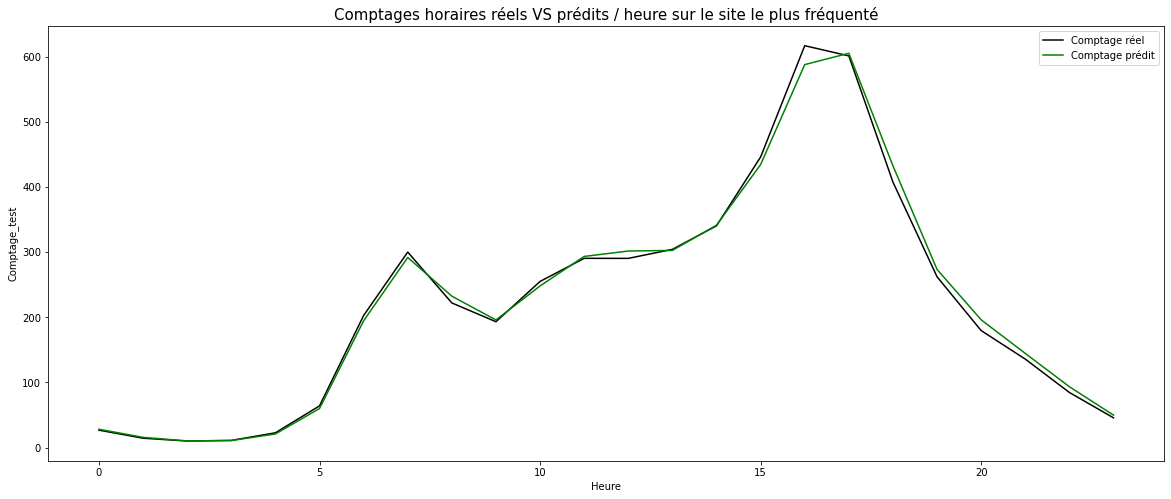

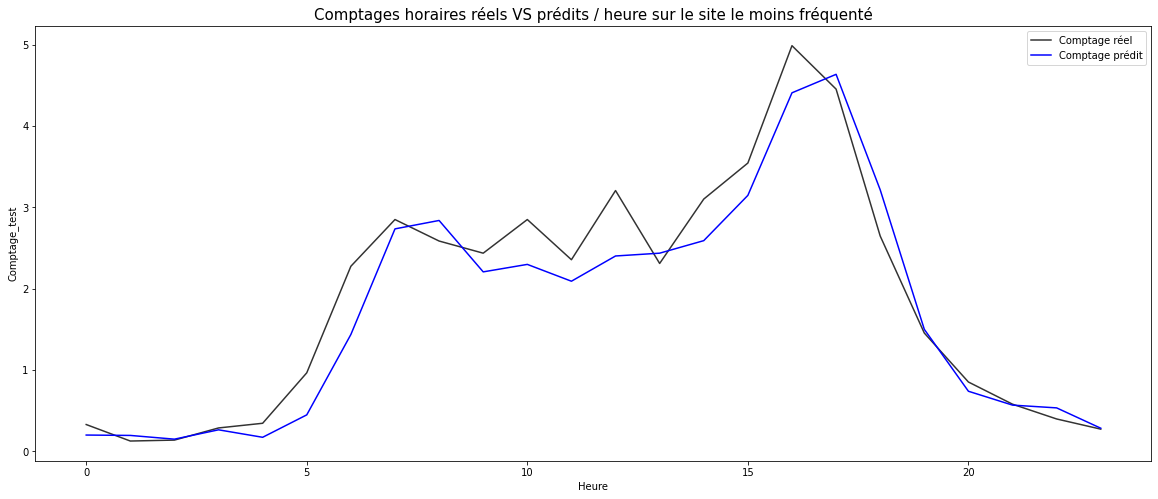

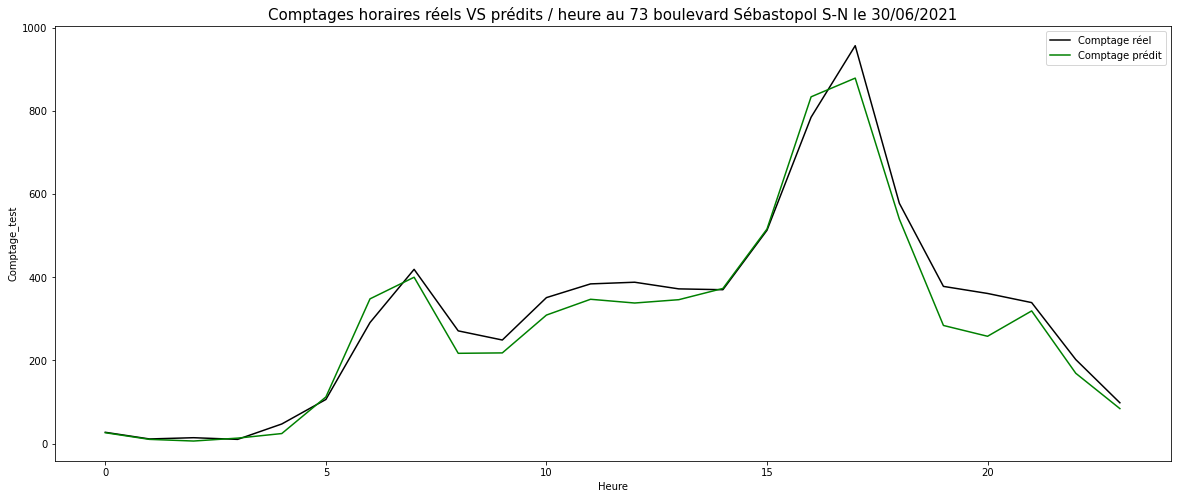

In [22]:
#Création d'un dataset limité aux données de test mais contenant toutes les données non encodées

df_test = df[df['Jour'] > 24]
df_test = df_test.sort_values(['Nom_compteur','Date','Heure'])
df_test['Comptage_test'] = y_test
df_test['Comptage_predict'] = y_pred_test_optimized.astype(int)
df_test['Heure'] = df['Heure'].apply(lambda x: int(x.strftime('%H')))

#Graphe de comparaison entre le comptage moyen réel et prédit sur le set de test sur le site le plus fréquenté
plt.figure(figsize = (20,8))
sns.lineplot(df_test.Heure, y='Comptage_test',color = 'black',ci = None, data = df_test.loc[df_test['Nom_compteur'] == "Totem 73 boulevard de Sébastopol S-N"], label ="Comptage réel")
sns.lineplot(df_test.Heure,y='Comptage_predict',color = 'green', ci = None, data = df_test.loc[df_test['Nom_compteur'] == "Totem 73 boulevard de Sébastopol S-N"], label ="Comptage prédit")
plt.title('Comptages horaires réels VS prédits / heure sur le site le plus fréquenté', fontsize = 15),
plt.legend();

#Graphe de comparaison entre le comptage moyen réel et prédit sur le set de test sur l'un des sites le moins fréquenté
plt.figure(figsize = (20,8))
sns.lineplot(df_test.Heure, y='Comptage_test', color = 'black', alpha = 0.8,ci = None, data = df_test.loc[df_test['Nom_compteur'] == "28 boulevard Diderot E-O"], label ="Comptage réel")
sns.lineplot(df_test.Heure,y='Comptage_predict',color = 'blue', ci = None, data = df_test.loc[df_test['Nom_compteur'] == "28 boulevard Diderot E-O"], label ="Comptage prédit")
plt.title('Comptages horaires réels VS prédits / heure sur le site le moins fréquenté', fontsize = 15),
plt.legend();

#Graphe de comparaison entre le comptage réel et prédit sur le set de test sur le site le plus fréquenté à une date précise

plt.figure(figsize = (20,8))
sns.lineplot(df_test.Heure, y='Comptage_test', color = 'black',ci = None, data = df_test.loc[(df_test['Nom_compteur'] == "Totem 73 boulevard de Sébastopol S-N") & (df_test['Date'] == "2021-06-30")], label ="Comptage réel")
sns.lineplot(df_test.Heure,y='Comptage_predict',color = 'green', ci = None, data = df_test.loc[(df_test['Nom_compteur'] == "Totem 73 boulevard de Sébastopol S-N") & (df_test['Date'] == "2021-06-30")], label ="Comptage prédit")
plt.title('Comptages horaires réels VS prédits / heure au 73 boulevard Sébastopol S-N le 30/06/2021', fontsize = 15),
plt.legend();

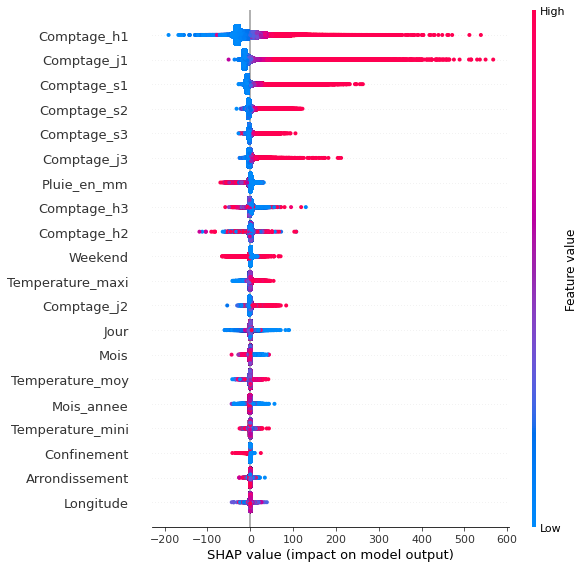

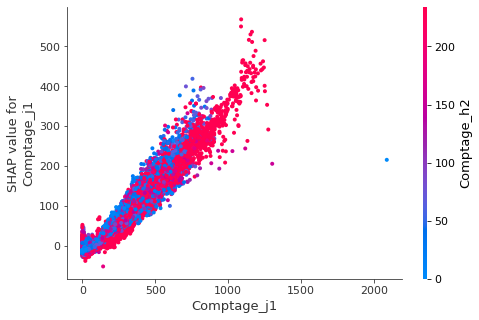

In [23]:
#Comprendre le modèle à l'aide de SHAP
shap.initjs()

# 'margin' est la vraie contribution de la variable à la prédiction de la variable cible
shap_values = shap.TreeExplainer(loaded_model, model_output='margin').shap_values(X_train)
shap.summary_plot(shap_values, X_train)
shap.dependence_plot('Comptage_j1', shap_values, X_train)